# Mask R-CNN - Train Seven Segment Display

Inspect and visualize data loading and pre-processing code.

#### PIP INSTALLATIONS
* pip install numpy scipy pillow cython matplotlib scikit-image opencv-python-headless h5py keras
* pip install tensorflow==2.2.0  # You may adjust the TensorFlow version if needed
* pip install imgaug
* pip install git+https://github.com/matterport/Mask_RCNN.git
Changed the model.py by replacing KE.Layers to KL.Layers 



### Import Packages

In [9]:
import os
import sys
import random
import json
import datetime
import math
import numpy as np
import skimage.io
import skimage.draw
import cv2

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

In [25]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.visualize import display_images


### Set Directory Path 

In [26]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../")

#Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
DEFAULT_LOGS_DIR =os.path.join(ROOT_DIR,"logs")


In [27]:

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "crop_images")

### Custom Configuration & Dataset & Training Functions

#### Configuration 
* Change NUM_CLASSES Based on number of chasses you have 
* NAME keep it like that no issue 

In [29]:

class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + car and truck

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [30]:
config = CustomConfig()

#### Dataset 
* Change the for annotations1 
* 'ssdisplay' is the label given when creating annotations in VGG 
* ssname is the name given when creating annotations in VGG 

In [31]:

class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Dog-Cat dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "ssdisplay")
        

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        
        if subset == 'train':
            # We mostly care about the x and y coordinates of each region
            annotations1 = json.load(open('G:\\My Drive\\02_Python_Projects\\Mask_RCNN\\train\\em_train.json'))
        else:
            annotations1 = json.load(open('G:\\My Drive\\02_Python_Projects\\Mask_RCNN\\val\\em_test.json'))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['ssname'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"ssdisplay": 1}

            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Dog-Cat dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [32]:
dataset = CustomDataset()
dataset.load_custom("G:\\My Drive\\02_Python_Projects\\Mask_RCNN", "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssd

### Display Samples 

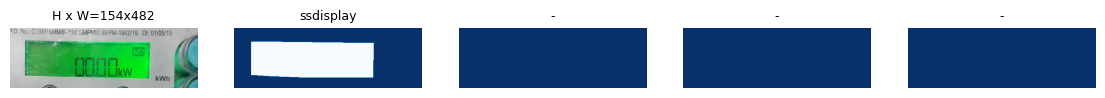

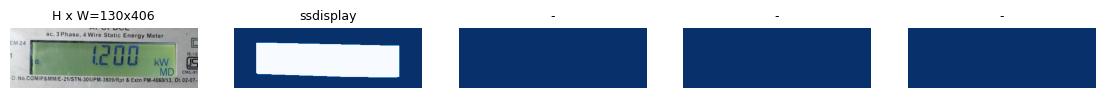

In [33]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 2)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [34]:
print(mask.shape , image.shape)

(130, 406, 1) (130, 406, 3)


### Bounding Boxes

Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

image_id  0 G:\My Drive\02_Python_Projects\Mask_RCNN\train\img1.jpg
image                    shape: (276, 667, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (276, 667, 1)         min:    0.00000  max:    1.00000  uint8
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:   65.00000  max:  570.00000  int32


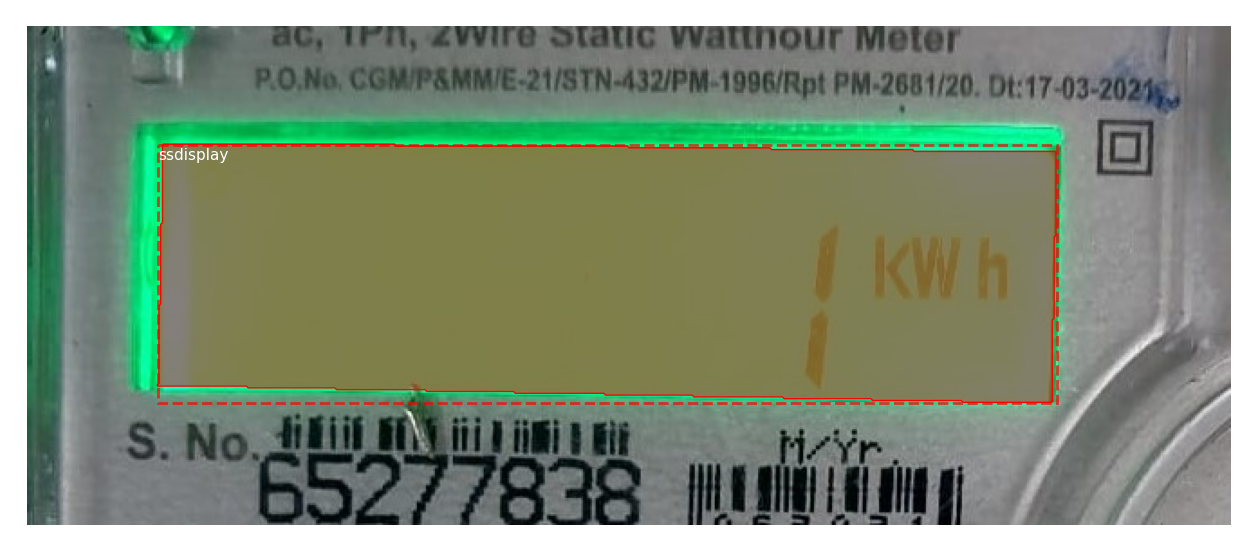

In [35]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

### Resize Images

To support multiple images per batch, images are resized to one size (1024x1024). Aspect ratio is preserved, though. If an image is not square, then zero padding is added at the top/bottom or right/left.

image_id:  1 G:\My Drive\02_Python_Projects\Mask_RCNN\train\img2.jpeg
Original shape:  (250, 687, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  152.00000  max:  874.00000  int32


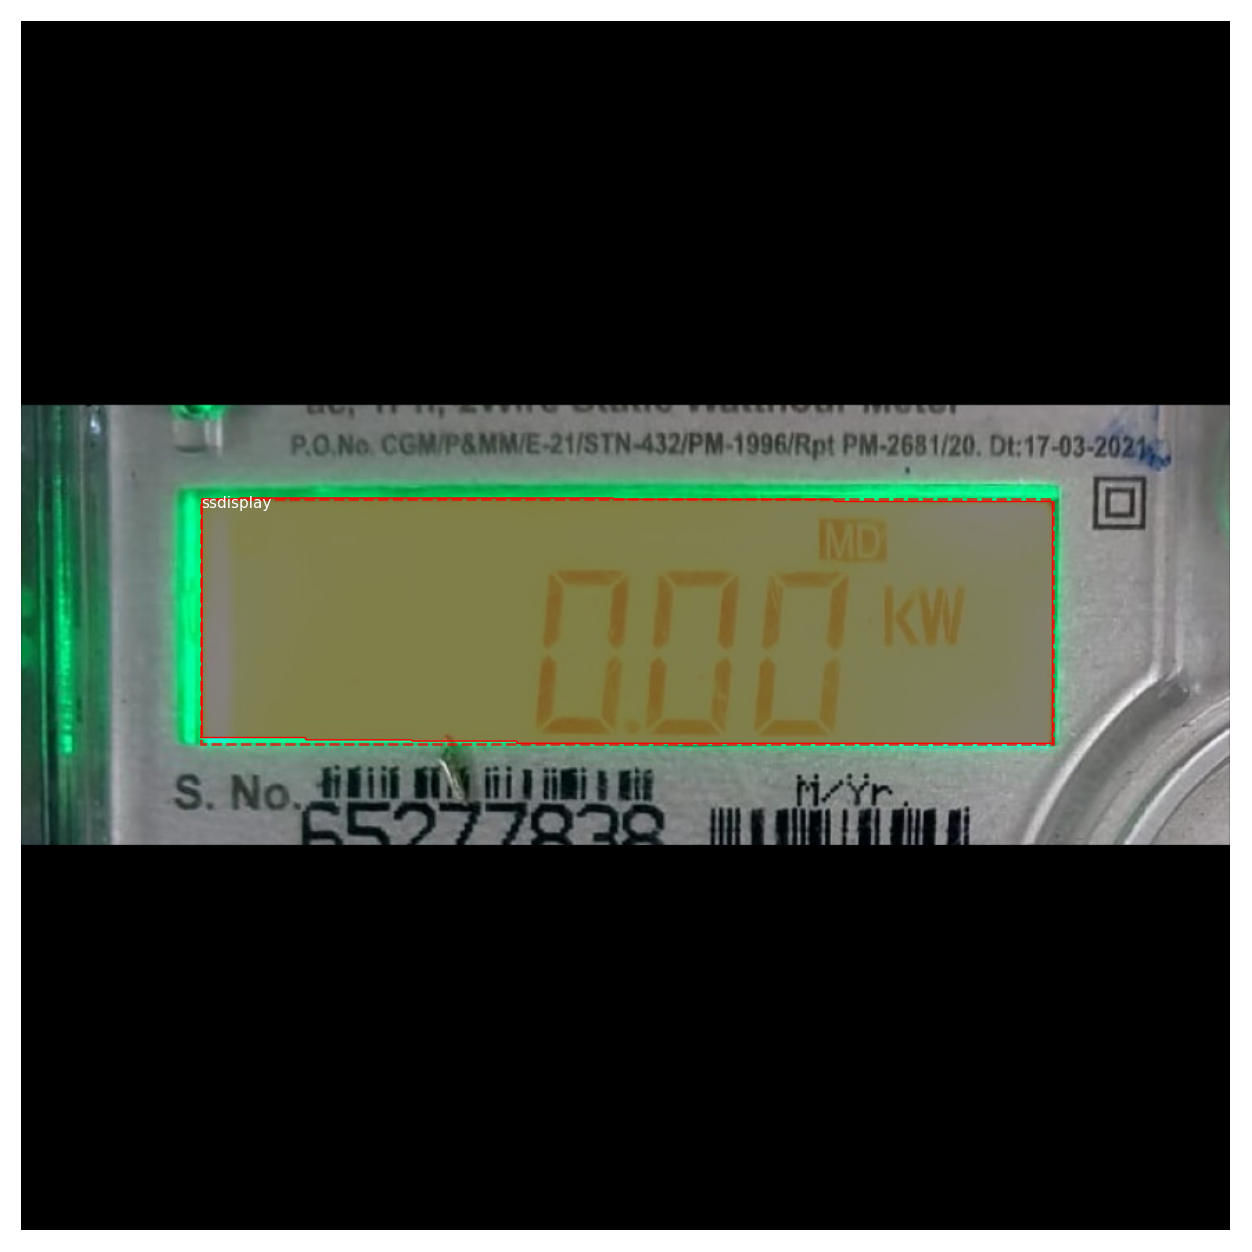

In [36]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

### Mini Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone. 

To improve training speed, we optimize masks by:
* We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
* We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  173.00000  max:  913.00000  int32
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


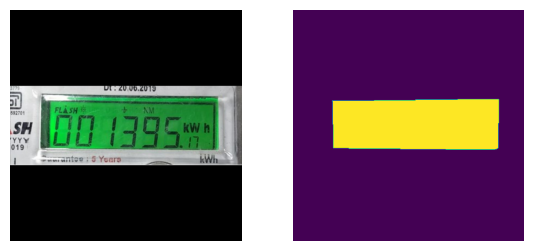

In [37]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

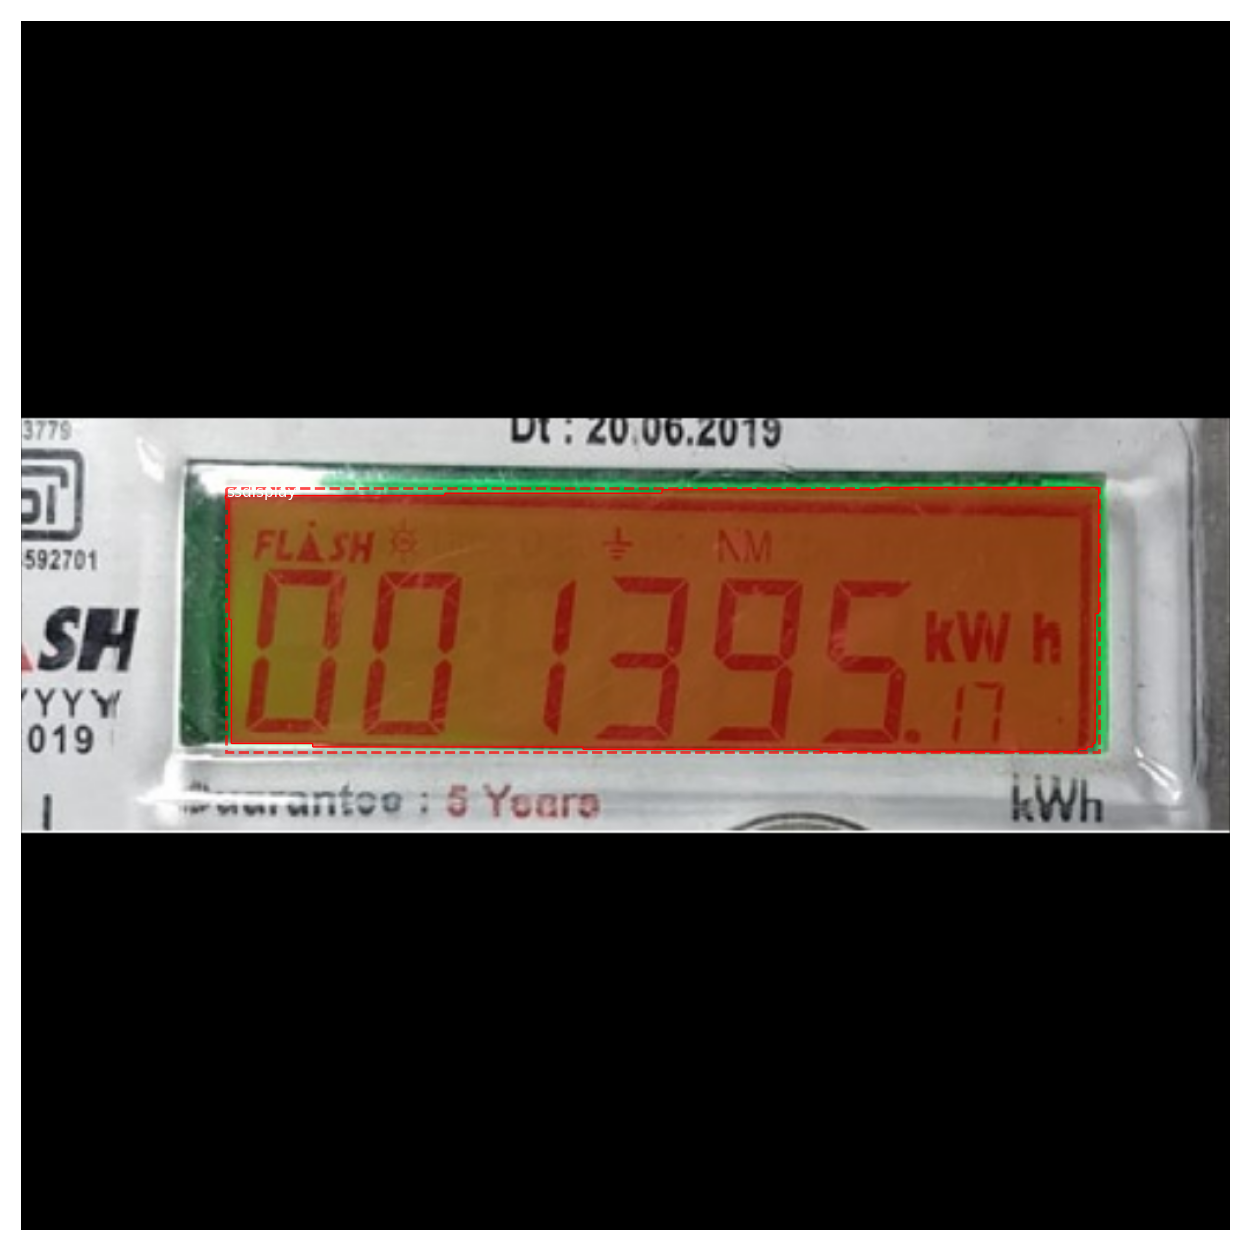

In [38]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 1)           min:    0.00000  max:    1.00000  bool


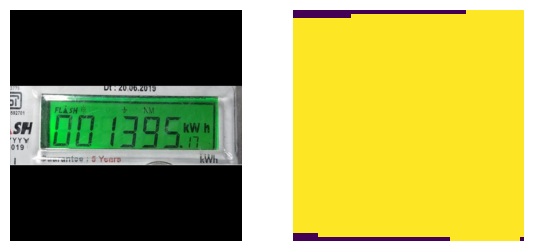

In [39]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

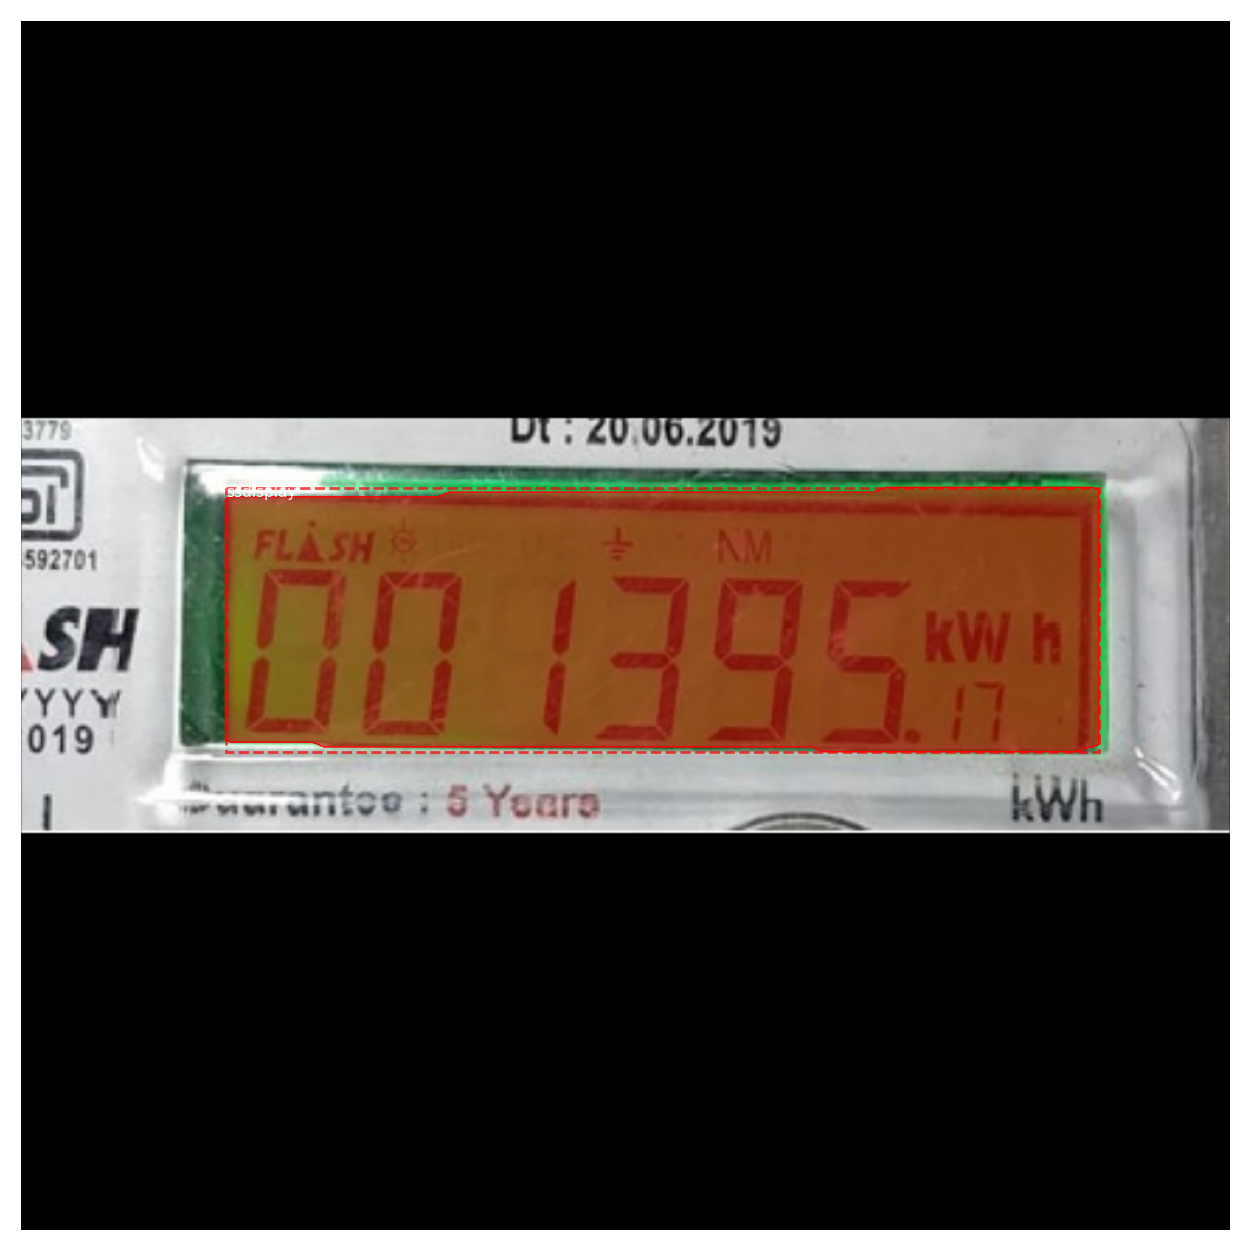

In [40]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

#### Train Model 
* epochs = 20 is given default but it is taking long time so, I am happy to update it to 1 to check 

In [42]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_custom("G:\\My Drive\\02_Python_Projects\\Mask_RCNN", "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomDataset()
    dataset_val.load_custom("G:\\My Drive\\02_Python_Projects\\Mask_RCNN", "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=10,
                layers='heads')

### Now Train The Model 

In [43]:

config = CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config, model_dir=DEFAULT_LOGS_DIR)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [44]:
weights_path = COCO_WEIGHTS_PATH
        # Download weights file
if not os.path.exists(weights_path):
    utils.download_trained_weights(weights_path)


In [45]:
train(model)

objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssd


C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
100/100 [==============================] - 3572s 36s/step - loss: 3.2952 - rpn_class_loss: 0.7904 - rpn_bbox_loss: 2.2507 - mrcnn_class_loss: 2.4307e-04 - mrcnn_bbox_loss: 0.2130 - mrcnn_mask_loss: 0.0409 - val_loss: 1.2918 - val_rpn_class_loss: 0.0180 - val_rpn_bbox_loss: 1.2737 - val_mrcnn_class_loss: 9.5367e-07 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00



Epoch 2/10
100/100 [==============================] - 3570s 36s/step - loss: 1.3088 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 1.2971 - mrcnn_class_loss: 1.3483e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 1.5371 - val_rpn_class_loss: 0.0096 - val_rpn_bbox_loss: 1.5275 - val_mrcnn_class_loss: 3.3379e-06 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 3/10
100/100 [==============================] - 3557s 36s/step - loss: 1.1220 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 1.1113 - mrcnn_class_loss: 3.6430e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 1.2013 - val_rpn_class_loss: 0.0092 - val_rpn_bbox_loss: 1.1921 - val_mrcnn_class_loss: 3.2186e-06 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 4/10
100/100 [==============================] - 3562s 36s/step - loss: 0.8800 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.8530 - mrcnn_class_loss: 6.0230e-05 - mrcnn_bbox_loss: 0.0087 - mr

Started at 03:58 
complited aroun 15:30 

### Data Generator

In [48]:
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [52]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 200, 4)           min:    0.00000  max: 1023.00000  int32
mrcnn_class_ids          shape: (4, 200, 1)           min:    0.00000  max:    1.00000  int32
mrcnn_bbox               shape: (4, 200, 2, 4)        min:   -3.37349  max:    3.29832  float32
mrcnn_mask               shape: (4, 200, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 100)              min:    0.00000  max:    1.00000  int32
gt_boxes                 shape: (4, 100, 4)           min:    0.00000  max:  911.00000  int32
gt_masks                 shape: (4, 56, 56, 100)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 261888, 1)        min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 256, 4)           min:   -3.01742  max:    1.21534  float64
image_id:  30 G:\My Drive\02_Python_Projects\Mask_RCNN\train\img31.jpg


In [55]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

NameError: name 'anchors' is not defined

In [54]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

NameError: name 'sample_image' is not defined